Number of samples: 10000
Normalizing data...
Shape of PCA data: (10000, 2)
Shape of t-SNE data: (10000, 2)
Calculating Trustworthiness...
Trustworthiness for PCA: 0.5170
Trustworthiness for t-SNE: 0.6746
Running t-SNE with Perplexity = 5...
Running t-SNE with Perplexity = 10...
Running t-SNE with Perplexity = 20...
Running t-SNE with Perplexity = 30...
Running t-SNE with Perplexity = 40...
Running t-SNE with Perplexity = 50...


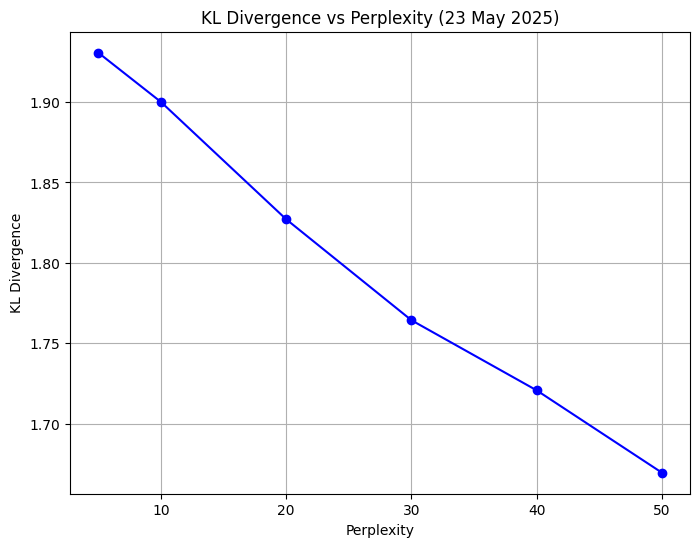

Optimal Perplexity with the lowest KL Divergence: 50
Chart saved at C:\Users\Asus\Downloads/kl_divergence_vs_perplexity.png.


In [ ]:
import sklearn
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## Loading MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='liac-arff')
X = X[:10000]
y = y[:10000]
print("Number of samples:", len(X))

print("Normalizing data...")
X = X / 255.0

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

print("Shape of PCA data:", X_pca.shape)
print("Shape of t-SNE data:", X_tsne.shape)

def trustworthiness(X, X_reduced, k=12):
    n_samples = X.shape[0]
    nn = NearestNeighbors(n_neighbors=k + 1, metric='euclidean').fit(X)
    indices_orig = nn.kneighbors(return_distance=False)[:, 1:]

    nn_reduced = NearestNeighbors(n_neighbors=k + 1, metric='euclidean').fit(X_reduced)
    indices_red = nn_reduced.kneighbors(return_distance=False)[:, 1:]

    sum_weights = 0
    for i in range(n_samples):
        not_neighbors = np.setdiff1d(indices_red[i], indices_orig[i], assume_unique=True)
        weights = [max(0, j - k + 1) for j in not_neighbors]
        sum_weights += sum(weights)

    return 1 - (2 * sum_weights) / (n_samples * k * (2 * n_samples - 3 * k - 1))

print("Calculating Trustworthiness...")
trustworthiness_pca = trustworthiness(X, X_pca, k=12)
trustworthiness_tsne = trustworthiness(X, X_tsne, k=12)

print(f"Trustworthiness for PCA: {trustworthiness_pca:.4f}")
print(f"Trustworthiness for t-SNE: {trustworthiness_tsne:.4f}")

perplexities = [5, 10, 20, 30, 40, 50]
kl_divergences = []

for perplexity in perplexities:
    print(f"Running t-SNE with Perplexity = {perplexity}...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X)
    kl_divergences.append(tsne.kl_divergence_)

plt.figure(figsize=(8, 6))
plt.plot(perplexities, kl_divergences, 'b-', marker='o')
plt.title('KL Divergence vs Perplexity (23 May 2025)')
plt.xlabel('Perplexity')
plt.ylabel('KL Divergence')
plt.grid(True)
plt.show()
plt.close()

optimal_perplexity = perplexities[np.argmin(kl_divergences)]
print(f"Optimal Perplexity with the lowest KL Divergence: {optimal_perplexity}")
print(f"Chart saved at {os.path.join(output_path, 'kl_divergence_vs_perplexity.png')}.")